In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss, GPU

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math, json
import numpy as np

import gymnasium as gym
import matplotlib.pyplot as plt

In [3]:
NUM_RUNS = 10

A = 256      # dimension of each hidden layer
B = 2       # number of hidden layers
C = 5e-3    # stochastic gradient descent learning rate
D = 8000      # maximum numbers of transitions stored by replay buffer
E = 250     # number of episodes of learning running the task
F = 1     # epsilon probability of eps-greedy policy
G = 0.99    # reward discounting factor
H = 128     # replay buffer sample size
I = 50      # The interval between two consecutive target network update

In [20]:
runs_results = []
env = gym.make('CartPole-v1')
# each run takes about 4.5-5 minutes
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    layers = [4] + [A]*B + [2]
    # layers = [4] + [8, 32, 8] + [2]
    policy_net = DQN(layers)
    target_net = DQN(layers)
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.SGD(policy_net.parameters(), lr=C)
    memory = ReplayBuffer(D)

    steps_done = 0
    episode_durations = []
    eps_decay = 1
    for i_episode in range(1, E+1):            
        if i_episode % 20 == 0:
            print("episode ", i_episode, "/", eps_decay, "...", episode_durations[-20:])
            
        observation, info = env.reset()
        state = torch.tensor(observation, device=GPU).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(F*eps_decay, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward], device=GPU)/G
            action = torch.tensor([action], device=GPU)
            next_state = torch.tensor(observation, device=GPU).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done], device=GPU)])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < H:
                transitions = memory.sample(H)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
            steps_done += 1
            # Update the target network, copying all weights and biases in DQN
            if steps_done % I == 0: 
                update_target(target_net, policy_net)

        if i_episode > 5 and eps_decay > 10e-3:
            eps_decay *= 0.98
        optimizer.param_groups[0]["lr"] = max(C/1000, optimizer.param_groups[0]["lr"]*0.98)
    runs_results.append(episode_durations)
    
with open("reward.json", "w") as f:
    json.dump(runs_results, f)
torch.save(policy_net.state_dict(), "policy.pkl")
print('Complete', steps_done)

Starting run 1 of 10


KeyboardInterrupt: 

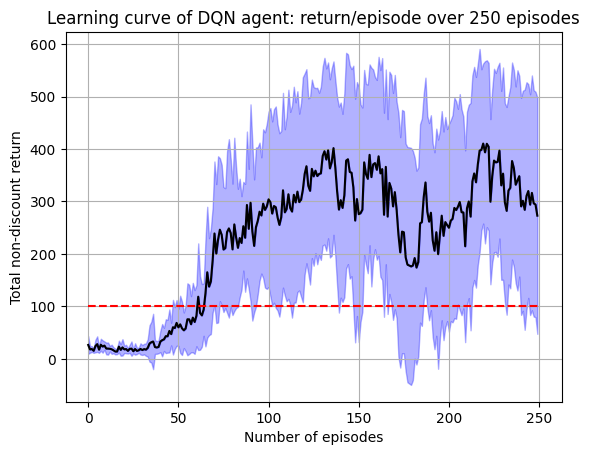

In [ ]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it

with open(f"reward{NUM_RUNS}.json", "r") as f:
    runs_results = json.load(f)
num_episodes = len(runs_results[0])
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)
plt.title("Learning curve of DQN agent: return/episode over 250 episodes")
plt.plot(torch.arange(num_episodes), means, color='k')
plt.hlines(100, 0, num_episodes,"r", "dashed")
plt.ylabel("Total non-discount return")
plt.xlabel("Number of episodes")
plt.grid()
plt.fill_between(np.arange(num_episodes), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(num_episodes), means, means-stds, alpha=0.3, color='b')
plt.savefig(f"static/reward{NUM_RUNS}.png")

In [23]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can freely modify these plots and code

# Make sure to include appropriate labels and/or legends when presenting your plot
policy_net = DQN([4] + [A]*B + [2])
policy_net.load_state_dict(torch.load("policy.pkl", weights_only=True))

angle_range = .21 # you may modify this range
omega_range = 1     # you may modify this range
angle_samples = 100
omega_samples = 100
# q = True    whether q values or greedy policy is visualised

def model_visual(velocity, q=True):
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., velocity, angle, omega], device=GPU)
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    plt.clf()
    if q:
        plt.title(f"Model Q-values at velocity={velocity}[unit/s]")
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
    else:
        plt.title(f"Model greedy policy at velocity={velocity}[unit/s]")
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        plt.grid()
    plt.colorbar()
    plt.hlines(0, -angle_range, angle_range, linestyles="dashed", colors="r")
    plt.vlines(0, -omega_range, omega_range, linestyles="dashed", colors="r")
    plt.xlabel("Pole angle [radian]")
    plt.ylabel("Angular velocity [radian/s]")
    plt.savefig(f"static/pol_v{velocity}_show_q={q}.png")


def animation():
    env = gym.make('CartPole-v1')
    env.reset()
    done, terminated = False, False
    observation, info = env.reset()
    state = torch.tensor(observation, device=GPU).float()
    frames = []

    import io
    from PIL import Image
    def add_frame():
        buf = io.BytesIO()
        fig = plt.gcf()
        fig.savefig(buf)
        buf.seek(0)
        im = Image.open(buf)
        plt.clf()
        frames.append(im)

    while not (done or terminated):
        q_vals = policy_net(state)
        greedy_action = q_vals.argmax().item()
        observation, reward, done, terminated, info = env.step(greedy_action)
        state = torch.tensor(observation, device=GPU).reshape(-1).float()
        x0 = observation[0]
        xd = x0 + (greedy_action-0.5)*2
        x1 = x0 + 3*np.sin(observation[2])
        y1 = 3*np.cos(observation[2])
        plt.title(f"Cartpole time step: {len(frames)}")
        plt.xlim((-2, 2))
        plt.ylim((-1, 4))
        plt.vlines(x0, -1, 4, linestyles="dashed")
        plt.plot([xd, x0, x1], [0,0,y1], color="g")
        plt.plot([x1-0.2, x1-0.2, x1+0.2, x1+0.2, x1-0.2], [y1-0.2, y1+0.2, y1+0.2, y1-0.2, y1-0.2])
        plt.scatter([0], [0], color="k")
        add_frame()
    
    frame_one = frames[0]
    frame_one.save(f"static/cartpole.gif", format="GIF", append_images=frames,
    save_all=True, duration=60, loop=0)

# for v in [0, 0.5, 1, 2]:
#     # model_visual(v, False)
#     model_visual(v, True)
animation()

<Figure size 640x480 with 0 Axes>